<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47703 entries, 0 to 47702
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      47703 non-null  float64
 1   data_inversa            47703 non-null  object 
 2   dia_semana              47703 non-null  object 
 3   horario                 47703 non-null  object 
 4   uf                      47703 non-null  object 
 5   br                      47703 non-null  int64  
 6   km                      47703 non-null  object 
 7   municipio               47703 non-null  object 
 8   causa_acidente          47703 non-null  object 
 9   tipo_acidente           47703 non-null  object 
 10  classificacao_acidente  47702 non-null  object 
 11  fase_dia                47703 non-null  object 
 12  sentido_via             47703 non-null  object 
 13  condicao_metereologica  47703 non-null  object 
 14  tipo_pista              47703 non-null

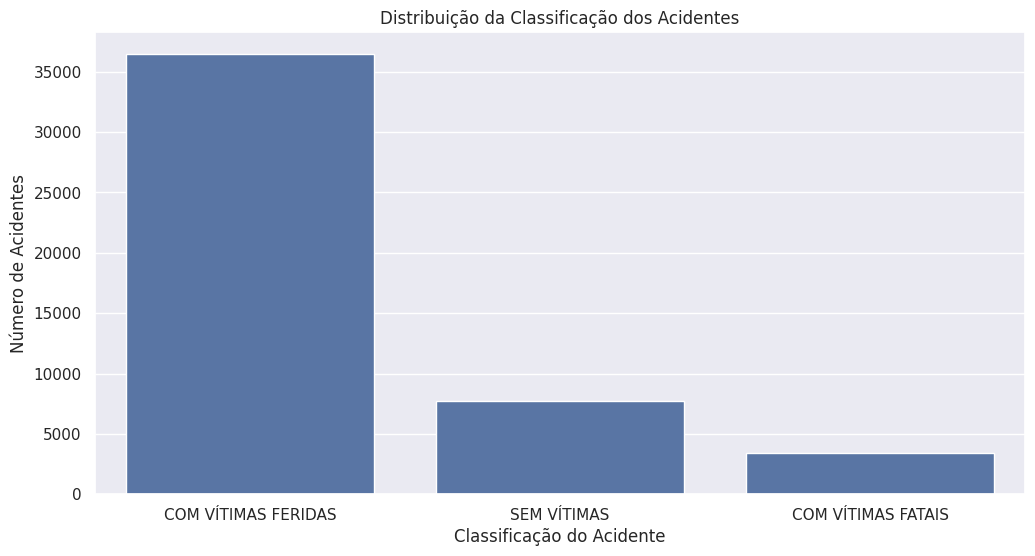

In [1]:
# 1. Importação de Bibliotecas e Configurações Iniciais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de plot
sns.set_style('darkgrid')
sns.set_theme(rc={'figure.figsize':(12,6)})

# 2. Carregamento e Pré-processamento dos Dados

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Importação adicional para calcular os pesos das classes
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# Carregamento dos dados
df = pd.read_csv('datatran2024.csv', sep=';', encoding='latin1')

# Verificação inicial
print(df.info())
print(df.head())

# 2.1. Tratamento de Valores Ausentes e Dados Duplicados

# Remover linhas com valores ausentes
df.dropna(inplace=True)

# Verificar duplicatas
df.drop_duplicates(inplace=True)

# Verificação após limpeza
print(df.info())

# 2.2. Conversão de Tipos de Dados

# Converter 'data_inversa' para datetime
df['data_inversa'] = pd.to_datetime(df['data_inversa'])

# Converter 'horario' para datetime.time
df['horario'] = pd.to_datetime(df['horario'], format='%H:%M:%S').dt.time

# Converter 'km' para float
df['km'] = df['km'].astype(str).str.replace(',', '.').astype(float)

# Converter 'latitude' e 'longitude' para float
df['latitude'] = df['latitude'].astype(str).str.replace(',', '.').astype(float)
df['longitude'] = df['longitude'].astype(str).str.replace(',', '.').astype(float)

# 2.3. Padronização de Strings

# Remover espaços extras e padronizar strings
cols_str = ['dia_semana', 'uf', 'municipio', 'causa_acidente', 'tipo_acidente',
            'classificacao_acidente', 'fase_dia', 'sentido_via', 'condicao_metereologica',
            'tipo_pista', 'tracado_via', 'uso_solo', 'regional', 'delegacia', 'uop']

for col in cols_str:
    df[col] = df[col].astype(str).str.strip().str.upper()

# 3. Análise Exploratória de Dados (EDA)
# Você pode incluir suas análises aqui, lembrando de adicionar plt.show() após cada plot.

# Exemplo:
# Distribuição da Classificação dos Acidentes
class_counts = df['classificacao_acidente'].value_counts()
sns.countplot(x='classificacao_acidente', data=df, order=class_counts.index)
plt.title('Distribuição da Classificação dos Acidentes')
plt.xlabel('Classificação do Acidente')
plt.ylabel('Número de Acidentes')
plt.show()

# Continue com as demais análises...


In [2]:
# 4. Feature Engineering

# Criar coluna 'HORA'
df['HORA'] = df['horario'].apply(lambda x: x.hour)

# Período do Dia
def get_periodo_dia(hora):
    if 5 <= hora < 12:
        return 'MANHÃ'
    elif 12 <= hora < 18:
        return 'TARDE'
    elif 18 <= hora < 24:
        return 'NOITE'
    else:
        return 'MADRUGADA'

df['PERIODO_DIA'] = df['HORA'].apply(get_periodo_dia)

# Final de Semana
df['FINAL_DE_SEMANA'] = df['dia_semana'].apply(lambda x: 1 if x in ['SÁBADO', 'DOMINGO'] else 0)

# Quantidade Total de Feridos
df['TOTAL_FERIDOS'] = df['feridos_leves'] + df['feridos_graves']

# Gravidade do Acidente (mapear para valores numéricos)
gravidade_mapping = {
    'SEM VÍTIMAS': 0,
    'COM VÍTIMAS FERIDAS': 1,
    'COM VÍTIMAS FATAIS': 2
}
df['GRAVIDADE'] = df['classificacao_acidente'].map(gravidade_mapping)

# 5. Preparação dos Dados para o Modelo

# Selecionar features e target
features = ['dia_semana', 'uf', 'causa_acidente', 'tipo_acidente', 
            'condicao_metereologica', 'tipo_pista', 'tracado_via', 
            'PERIODO_DIA', 'sentido_via', 'uso_solo', 'fase_dia', 
            'FINAL_DE_SEMANA', 'HORA', 'km', 'veiculos', 'pessoas', 
            'TOTAL_FERIDOS']

X = df[features]
y = df['GRAVIDADE']

# Identificar colunas categóricas e numéricas
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Padronização das variáveis numéricas
scaler = StandardScaler()
X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])

# Divisão em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

In [3]:

# 5.1. Cálculo dos Pesos das Classes

from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# Calcular os pesos das classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

print("Class Weights:", class_weights)

# Calcular os sample weights para XGBoost
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# 6. Definição de Funções Auxiliares

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Função para treinar e avaliar modelos
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, sample_weights=None):
    # Treinar o modelo
    if sample_weights is not None:
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)
    
    # Prever no conjunto de teste
    y_pred = model.predict(X_test)
    
    # Avaliar o modelo
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Sem Vítimas', 'Com Vítimas Feridas', 'Com Vítimas Fatais'], output_dict=True)
    
    # Exibir resultados
    print(f"Modelo: {model_name}")
    print("Accuracy:", accuracy)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Sem Vítimas', 'Com Vítimas Feridas', 'Com Vítimas Fatais']))
    
    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Sem Vítimas', 'Com Vítimas Feridas', 'Com Vítimas Fatais'], 
                yticklabels=['Sem Vítimas', 'Com Vítimas Feridas', 'Com Vítimas Fatais'])
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()
    
    return accuracy, report

# Função para aplicar técnicas de balanceamento
def apply_sampling(sampling_technique, X_train, y_train):
    if sampling_technique == 'SMOTE':
        sampler = SMOTE(random_state=42)
    elif sampling_technique == 'SMOTEENN':
        sampler = SMOTEENN(random_state=42)
    else:
        return X_train, y_train  # Sem balanceamento
    
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# Função para realizar GridSearchCV
def perform_grid_search(model, param_grid, X, y, sample_weights=None, scoring='f1_macro'):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,
        scoring=scoring,
        n_jobs=-1
    )
    if sample_weights is not None:
        grid_search.fit(X, y, sample_weight=sample_weights)
    else:
        grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print(f"Melhores hiperparâmetros para {model.__class__.__name__}:")
    print(grid_search.best_params_)
    return best_model

# 7. Avaliação dos Modelos em Diferentes Cenários

# 7.1. Definição dos Modelos

# Modelos a serem avaliados
models = {
    'Random Forest': RandomForestClassifier(class_weight=class_weights, random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='mlogloss', random_state=42),
    'Logistic Regression': LogisticRegression(class_weight=class_weights, max_iter=5000, random_state=42)
}



Class Weights: {np.int64(0): np.float64(2.044544625127462), np.int64(1): np.float64(0.4354823959762231), np.int64(2): np.float64(4.6600611620795105)}



Avaliação do Random Forest com Class Weights:
Modelo: Random Forest com Class Weights
Accuracy: 0.9439370078740158

Classification Report:
                     precision    recall  f1-score   support

        Sem Vítimas       0.87      0.97      0.92      1553
Com Vítimas Feridas       0.96      1.00      0.98      7291
 Com Vítimas Fatais       0.83      0.28      0.42       681

           accuracy                           0.94      9525
          macro avg       0.89      0.75      0.77      9525
       weighted avg       0.94      0.94      0.93      9525



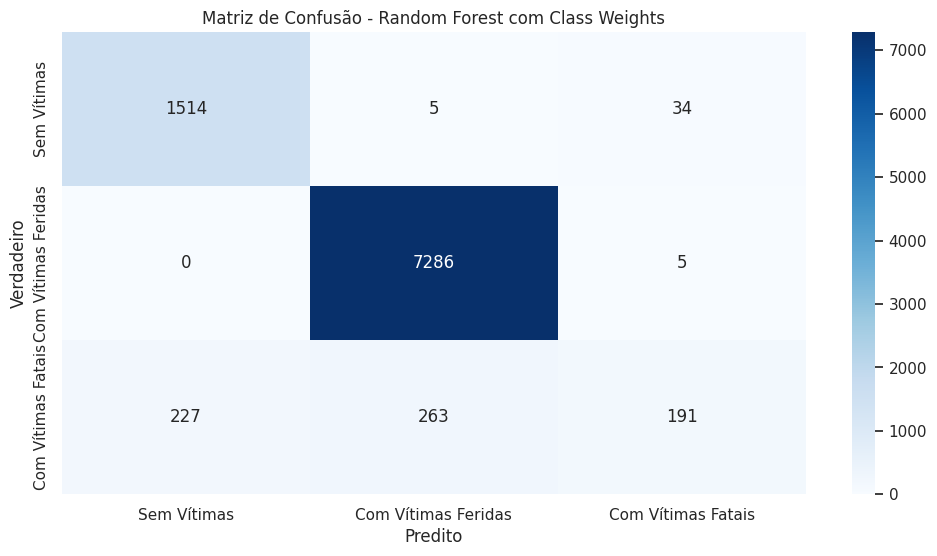


Avaliação do XGBoost com Class Weights:
Modelo: XGBoost com Class Weights
Accuracy: 0.9130708661417323

Classification Report:
                     precision    recall  f1-score   support

        Sem Vítimas       0.90      0.93      0.91      1553
Com Vítimas Feridas       0.98      0.94      0.96      7291
 Com Vítimas Fatais       0.42      0.59      0.49       681

           accuracy                           0.91      9525
          macro avg       0.77      0.82      0.79      9525
       weighted avg       0.93      0.91      0.92      9525



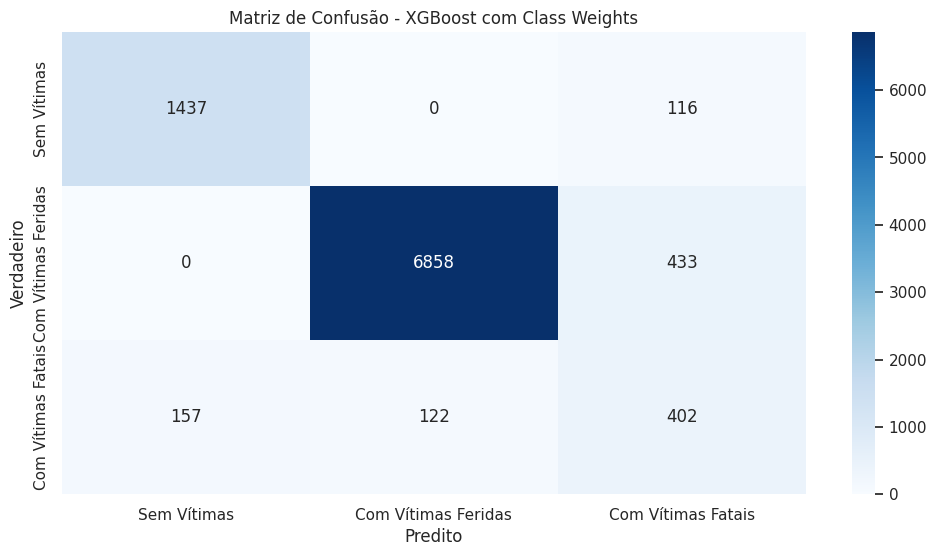


Avaliação do Logistic Regression com Class Weights:
Modelo: Logistic Regression com Class Weights
Accuracy: 0.8422047244094488

Classification Report:
                     precision    recall  f1-score   support

        Sem Vítimas       0.90      0.92      0.91      1553
Com Vítimas Feridas       0.99      0.85      0.91      7291
 Com Vítimas Fatais       0.26      0.64      0.37       681

           accuracy                           0.84      9525
          macro avg       0.71      0.80      0.73      9525
       weighted avg       0.92      0.84      0.87      9525



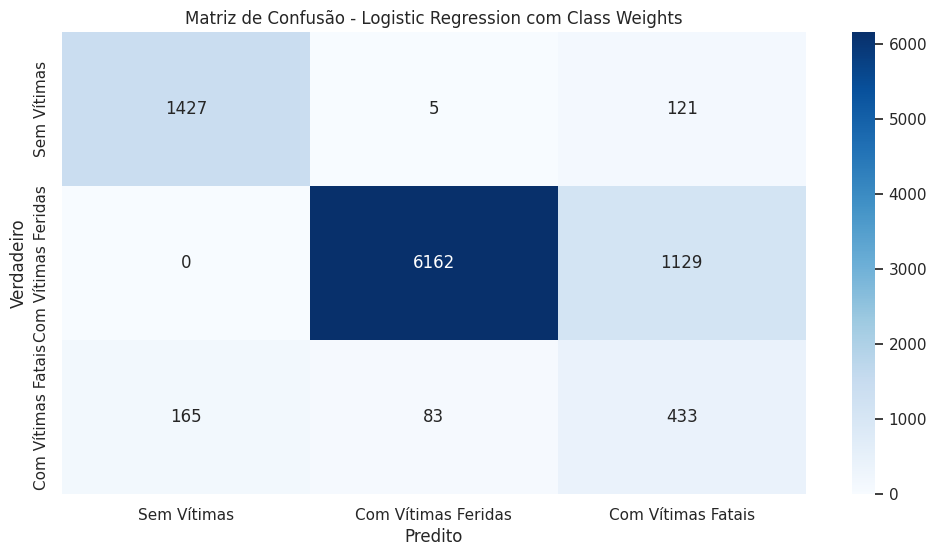


Avaliação do Random Forest com SMOTE e Class Weights:
Modelo: Random Forest com SMOTE e Class Weights
Accuracy: 0.9449868766404199

Classification Report:
                     precision    recall  f1-score   support

        Sem Vítimas       0.87      0.97      0.92      1553
Com Vítimas Feridas       0.97      1.00      0.98      7291
 Com Vítimas Fatais       0.76      0.34      0.47       681

           accuracy                           0.94      9525
          macro avg       0.87      0.77      0.79      9525
       weighted avg       0.94      0.94      0.94      9525



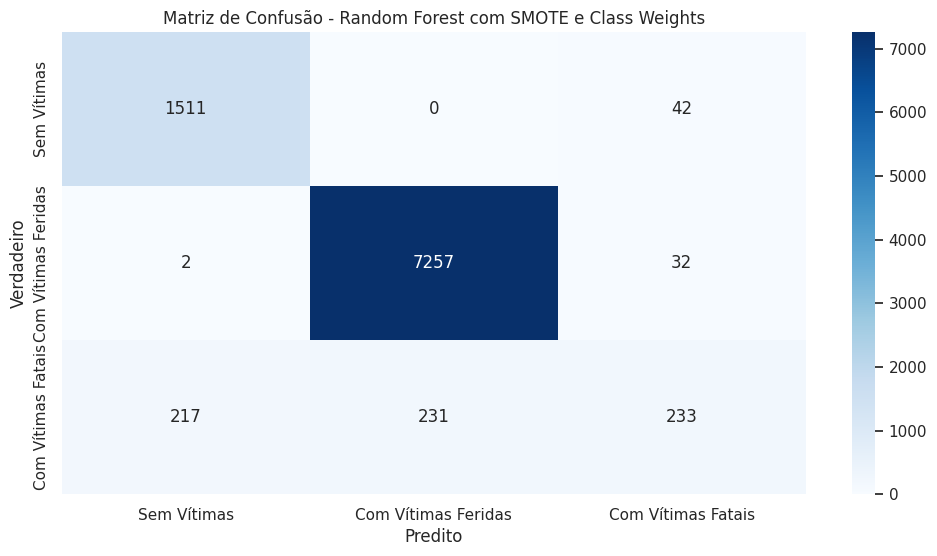


Avaliação do XGBoost com SMOTE e Class Weights:
Modelo: XGBoost com SMOTE e Class Weights
Accuracy: 0.9443569553805774

Classification Report:
                     precision    recall  f1-score   support

        Sem Vítimas       0.89      0.96      0.92      1553
Com Vítimas Feridas       0.97      0.99      0.98      7291
 Com Vítimas Fatais       0.69      0.41      0.51       681

           accuracy                           0.94      9525
          macro avg       0.85      0.79      0.80      9525
       weighted avg       0.94      0.94      0.94      9525



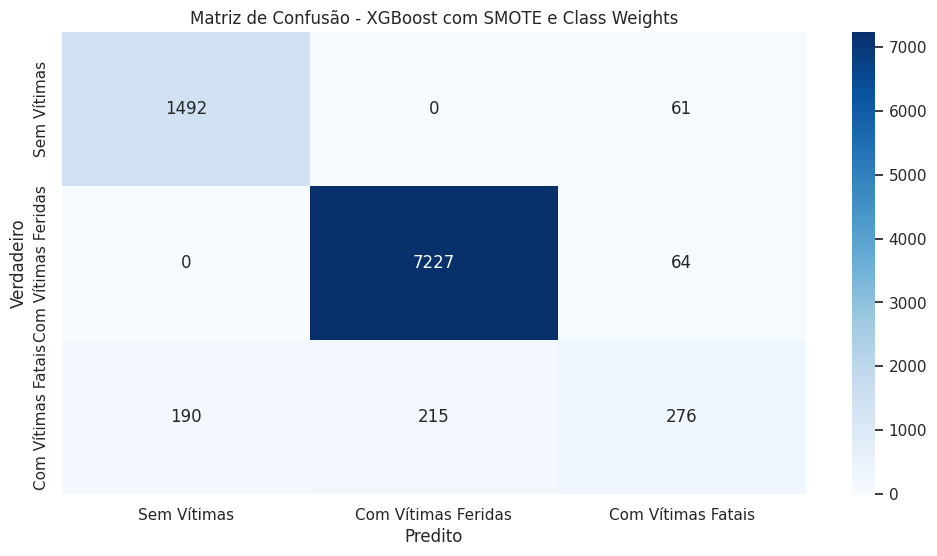


Avaliação do Logistic Regression com SMOTE e Class Weights:
Modelo: Logistic Regression com SMOTE e Class Weights
Accuracy: 0.9255643044619423

Classification Report:
                     precision    recall  f1-score   support

        Sem Vítimas       0.87      0.96      0.91      1553
Com Vítimas Feridas       0.96      0.98      0.97      7291
 Com Vítimas Fatais       0.51      0.27      0.35       681

           accuracy                           0.93      9525
          macro avg       0.78      0.74      0.75      9525
       weighted avg       0.91      0.93      0.92      9525



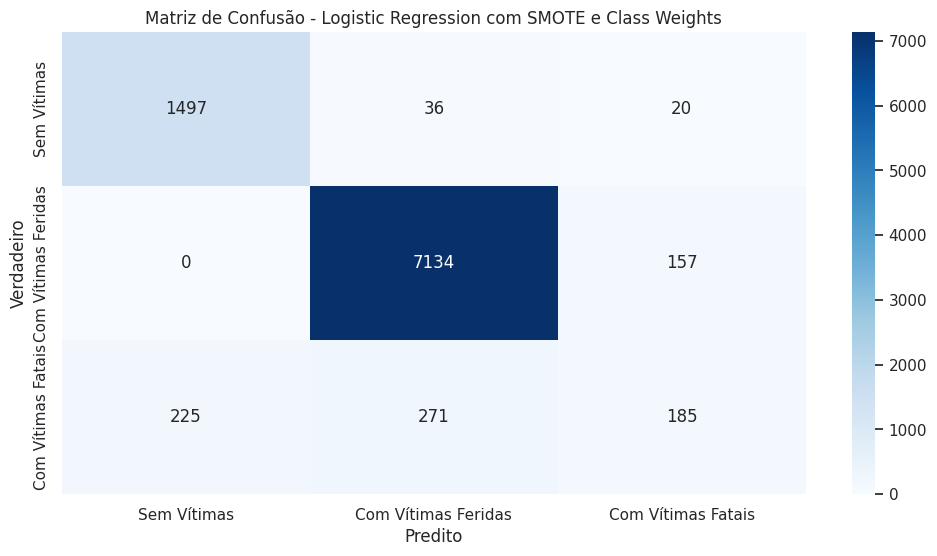


Avaliação do Random Forest com SMOTEENN e Class Weights:
Modelo: Random Forest com SMOTEENN e Class Weights
Accuracy: 0.9211548556430447

Classification Report:
                     precision    recall  f1-score   support

        Sem Vítimas       0.87      0.97      0.92      1553
Com Vítimas Feridas       0.98      0.95      0.97      7291
 Com Vítimas Fatais       0.46      0.48      0.47       681

           accuracy                           0.92      9525
          macro avg       0.77      0.80      0.78      9525
       weighted avg       0.93      0.92      0.92      9525



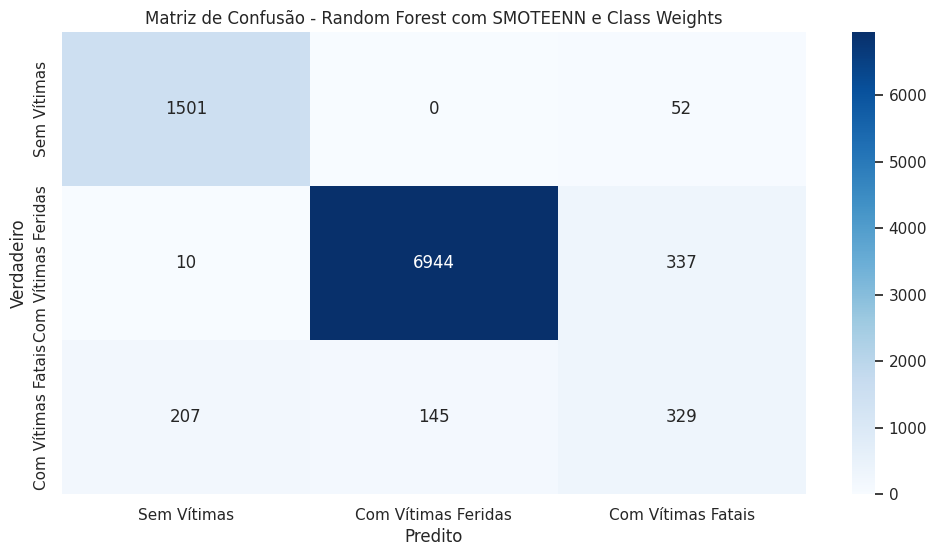


Avaliação do XGBoost com SMOTEENN e Class Weights:
Modelo: XGBoost com SMOTEENN e Class Weights
Accuracy: 0.9276640419947506

Classification Report:
                     precision    recall  f1-score   support

        Sem Vítimas       0.89      0.96      0.92      1553
Com Vítimas Feridas       0.98      0.96      0.97      7291
 Com Vítimas Fatais       0.49      0.51      0.50       681

           accuracy                           0.93      9525
          macro avg       0.79      0.81      0.80      9525
       weighted avg       0.93      0.93      0.93      9525



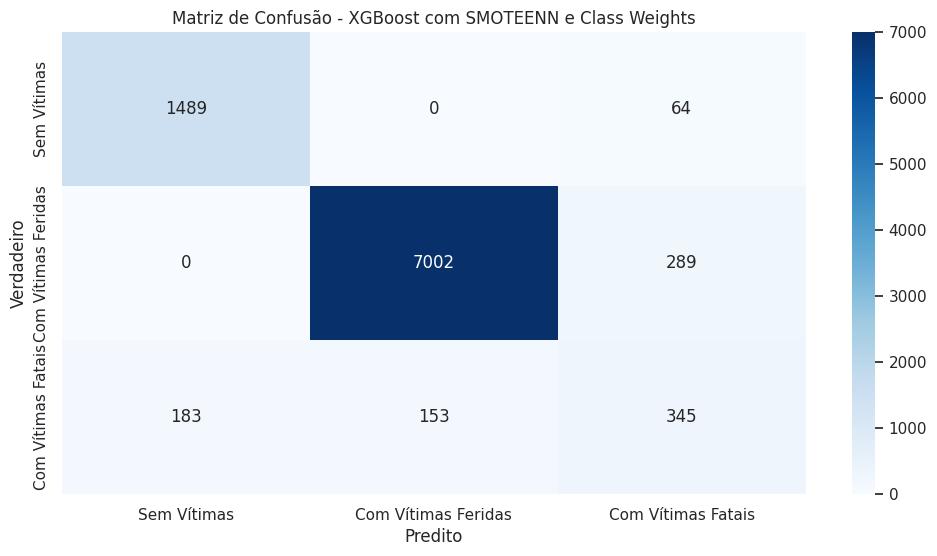


Avaliação do Logistic Regression com SMOTEENN e Class Weights:
Modelo: Logistic Regression com SMOTEENN e Class Weights
Accuracy: 0.8993175853018373

Classification Report:
                     precision    recall  f1-score   support

        Sem Vítimas       0.87      0.96      0.91      1553
Com Vítimas Feridas       0.97      0.93      0.95      7291
 Com Vítimas Fatais       0.34      0.39      0.36       681

           accuracy                           0.90      9525
          macro avg       0.73      0.76      0.74      9525
       weighted avg       0.91      0.90      0.90      9525



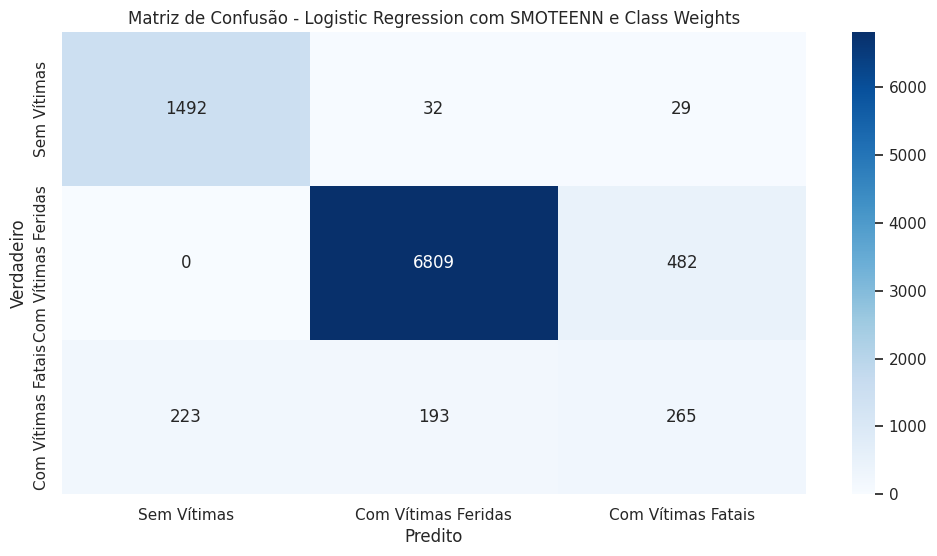


Avaliação do Random Forest com SMOTEENN, Class Weights e GridSearchCV:
Melhores hiperparâmetros para RandomForestClassifier:
{'class_weight': {np.int64(0): np.float64(0.861433327492553), np.int64(1): np.float64(1.5296204107031737), np.int64(2): np.float64(0.8436062873223968)}, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Modelo: Random Forest Otimizado com SMOTEENN e Class Weights
Accuracy: 0.9205249343832022

Classification Report:
                     precision    recall  f1-score   support

        Sem Vítimas       0.87      0.97      0.92      1553
Com Vítimas Feridas       0.98      0.95      0.97      7291
 Com Vítimas Fatais       0.45      0.47      0.46       681

           accuracy                           0.92      9525
          macro avg       0.77      0.80      0.78      9525
       weighted avg       0.92      0.92      0.92      9525



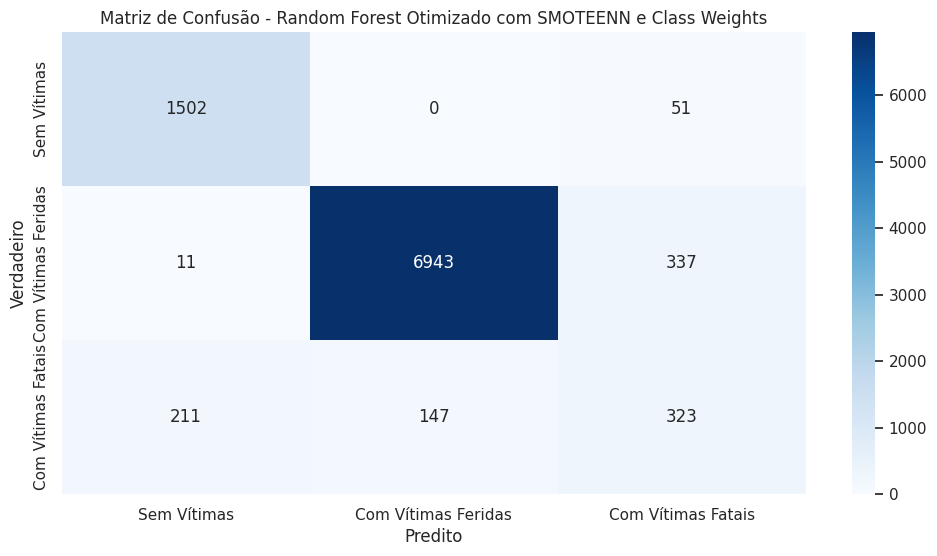


Avaliação do XGBoost com SMOTEENN, Class Weights e GridSearchCV:
Melhores hiperparâmetros para XGBClassifier:
{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
Modelo: XGBoost Otimizado com SMOTEENN e Class Weights
Accuracy: 0.9203149606299212

Classification Report:
                     precision    recall  f1-score   support

        Sem Vítimas       0.90      0.95      0.92      1553
Com Vítimas Feridas       0.98      0.95      0.96      7291
 Com Vítimas Fatais       0.45      0.54      0.49       681

           accuracy                           0.92      9525
          macro avg       0.78      0.81      0.79      9525
       weighted avg       0.93      0.92      0.92      9525



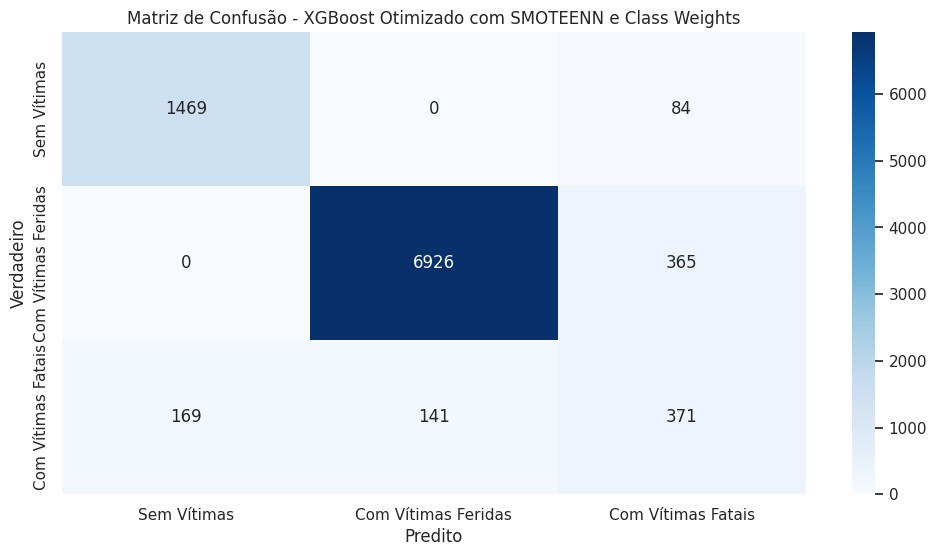


Avaliação do Logistic Regression com SMOTEENN, Class Weights e GridSearchCV:


KeyError: 'Logistic Regression'

In [4]:
# 7.2. Avaliação com Class Weights

# Dicionário para armazenar os resultados
results = {}

for model_name, model in models.items():
    if model_name == 'XGBoost':
        print(f"\nAvaliação do {model_name} com Class Weights:")
        accuracy, report = train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name + " com Class Weights", sample_weights=sample_weights)
    else:
        print(f"\nAvaliação do {model_name} com Class Weights:")
        accuracy, report = train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name + " com Class Weights")
    results[(model_name, 'Class Weights')] = report

# 7.3. Avaliação com SMOTE e Class Weights

# Aplicar SMOTE
X_train_smote, y_train_smote = apply_sampling('SMOTE', X_train, y_train)

# Recalcular os pesos das classes para o novo conjunto
class_weights_smote = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_smote), y=y_train_smote)
class_weights_smote = dict(zip(np.unique(y_train_smote), class_weights_smote))
sample_weights_smote = compute_sample_weight(class_weight='balanced', y=y_train_smote)

for model_name, model in models.items():
    if model_name == 'XGBoost':
        print(f"\nAvaliação do {model_name} com SMOTE e Class Weights:")
        # Atualizar o modelo com os novos sample weights
        model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)
        accuracy, report = train_evaluate_model(model, X_train_smote, y_train_smote, X_test, y_test, model_name + " com SMOTE e Class Weights", sample_weights=sample_weights_smote)
    else:
        print(f"\nAvaliação do {model_name} com SMOTE e Class Weights:")
        # Atualizar o modelo com os novos class weights
        model.set_params(class_weight=class_weights_smote)
        accuracy, report = train_evaluate_model(model, X_train_smote, y_train_smote, X_test, y_test, model_name + " com SMOTE e Class Weights")
    results[(model_name, 'SMOTE + Class Weights')] = report

# 7.4. Avaliação com SMOTEENN e Class Weights

# Aplicar SMOTEENN
X_train_smoteenn, y_train_smoteenn = apply_sampling('SMOTEENN', X_train, y_train)

# Recalcular os pesos das classes para o novo conjunto
class_weights_smoteenn = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_smoteenn), y=y_train_smoteenn)
class_weights_smoteenn = dict(zip(np.unique(y_train_smoteenn), class_weights_smoteenn))
sample_weights_smoteenn = compute_sample_weight(class_weight='balanced', y=y_train_smoteenn)

for model_name, model in models.items():
    if model_name == 'XGBoost':
        print(f"\nAvaliação do {model_name} com SMOTEENN e Class Weights:")
        # Atualizar o modelo com os novos sample weights
        model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)
        accuracy, report = train_evaluate_model(model, X_train_smoteenn, y_train_smoteenn, X_test, y_test, model_name + " com SMOTEENN e Class Weights", sample_weights=sample_weights_smoteenn)
    else:
        print(f"\nAvaliação do {model_name} com SMOTEENN e Class Weights:")
        # Atualizar o modelo com os novos class weights
        model.set_params(class_weight=class_weights_smoteenn)
        accuracy, report = train_evaluate_model(model, X_train_smoteenn, y_train_smoteenn, X_test, y_test, model_name + " com SMOTEENN e Class Weights")
    results[(model_name, 'SMOTEENN + Class Weights')] = report

# 7.5. Avaliação com SMOTEENN, Class Weights e GridSearchCV

# Parâmetros para GridSearchCV
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'class_weight': [class_weights_smoteenn, 'balanced', None]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    #'Logistic Regression': {
    #    'penalty': ['l2'], 
    #    'C': [0.1, 1.0, 10.0],
    #    'class_weight': [class_weights_smoteenn, 'balanced', None],
    #    'solver': ['lbfgs', 'saga']
    #}
}

for model_name, model in models.items():
    print(f"\nAvaliação do {model_name} com SMOTEENN, Class Weights e GridSearchCV:")
    param_grid = param_grids[model_name]
    if model_name == 'XGBoost':
        best_model = perform_grid_search(model, param_grid, X_train_smoteenn, y_train_smoteenn, sample_weights=sample_weights_smoteenn)
        accuracy, report = train_evaluate_model(best_model, X_train_smoteenn, y_train_smoteenn, X_test, y_test, model_name + " Otimizado com SMOTEENN e Class Weights", sample_weights=sample_weights_smoteenn)
    else:
        best_model = perform_grid_search(model, param_grid, X_train_smoteenn, y_train_smoteenn)
        accuracy, report = train_evaluate_model(best_model, X_train_smoteenn, y_train_smoteenn, X_test, y_test, model_name + " Otimizado com SMOTEENN e Class Weights")
    results[(model_name, 'SMOTEENN + Class Weights + GridSearchCV')] = report



In [5]:
# 8. Comparação dos Resultados em uma Tabela

# Criar uma tabela consolidada com as principais métricas
# Definir as métricas e a classe de interesse
metrics = ['precision', 'recall', 'f1-score']
classe_interesse = 'Com Vítimas Fatais'

rows = []
for (model_name, scenario), report in results.items():
    row = {
        'Modelo': model_name,
        'Cenário': scenario
    }
    for metric in metrics:
        row[metric] = report[classe_interesse][metric]
    rows.append(row)

# Criar DataFrame com os resultados
results_df = pd.DataFrame(rows)

# Ordenar o DataFrame pela métrica desejada (por exemplo, f1-score) em ordem decrescente
results_df_sorted = results_df.sort_values(by='f1-score', ascending=False)

# Exibir os resultados
print("Resultados para a classe 'Com Vítimas Fatais' ordenados por f1-score:")
print(results_df_sorted)

Resultados para a classe 'Com Vítimas Fatais' ordenados por f1-score:
                 Modelo                                  Cenário  precision  \
4               XGBoost                    SMOTE + Class Weights   0.688279   
7               XGBoost                 SMOTEENN + Class Weights   0.494269   
10              XGBoost  SMOTEENN + Class Weights + GridSearchCV   0.452439   
1               XGBoost                            Class Weights   0.422713   
3         Random Forest                    SMOTE + Class Weights   0.758958   
6         Random Forest                 SMOTEENN + Class Weights   0.458217   
9         Random Forest  SMOTEENN + Class Weights + GridSearchCV   0.454290   
0         Random Forest                            Class Weights   0.830435   
2   Logistic Regression                            Class Weights   0.257279   
8   Logistic Regression                 SMOTEENN + Class Weights   0.341495   
5   Logistic Regression                    SMOTE + Class Weig

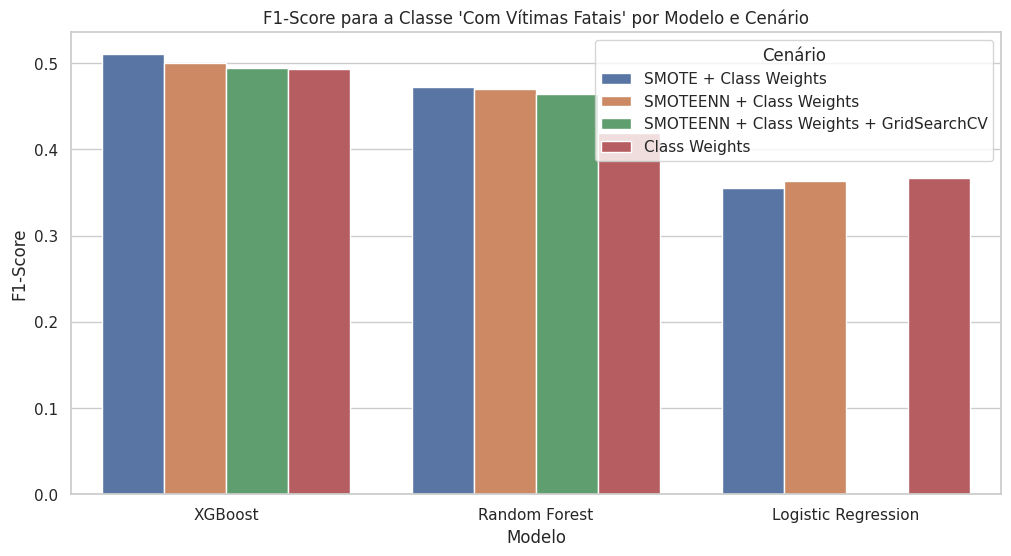

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar o estilo do Seaborn
sns.set(style="whitegrid")

# Criar um gráfico de barras para o f1-score
plt.figure(figsize=(12, 6))
sns.barplot(x='Modelo', y='f1-score', hue='Cenário', data=results_df_sorted)
plt.title("F1-Score para a Classe 'Com Vítimas Fatais' por Modelo e Cenário")
plt.ylabel("F1-Score")
plt.xlabel("Modelo")
plt.legend(title='Cenário')
plt.show()
